# Multiclass Variational Quantum Classifier

In [57]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#myqlm
from qat.lang.AQASM import Program, H, RX, RY, RZ, Z, CNOT
from qat.lang.AQASM import *
from qat.qpus import get_default_qpu
from qat.core import Observable, Term
from qat.plugins import ScipyMinimizePlugin

#imports
import ipynb
import import_ipynb
from vqc_functions import data_embedding, ansatz

## Data importing and preprocessing

MinMax with feature range from $0$ to $2\pi$.

In [58]:
data = pd.read_csv(r'C:\\Users\\anton.albino\\Documents\\Anton\\codigos\\myqlm\\qnn\\data\\iris.data')
label = data.iloc[:, -1]
features = data.iloc[:, :-1]

In [59]:
x = features.values #returns a numpy array
#data normalization (angles from 0 to 2pi)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 2*np.pi))
x_scaled = min_max_scaler.fit_transform(x)
features = pd.DataFrame(x_scaled)
data = features.assign(labels = label)

#spliting data
training_data, testing_data = train_test_split(data, test_size=0.2, random_state=25)
training_features = training_data.iloc[:, :-1]
training_labels = training_data.iloc[:, -1]
testing_features = testing_data.iloc[:, :-1]
testing_labels = testing_data.iloc[:, -1]

### TwoHot encoding

Encoding labels into quantum state in a following settings:

$3: |0011\rangle$ encoding Iris-setosa.
$6: |0110\rangle$ encoding Iris-versicolor.
$9: |1010\rangle$ encoding Iris-virginica.



In [60]:
twohotencoding_training = []
for i, iris in enumerate(training_labels):
    if iris == "Iris-setosa":
        twohotencoding_training.append(3)
    elif iris == "Iris-versicolor":
        twohotencoding_training.append(6)
    elif iris == "Iris-virginica":
        twohotencoding_training.append(9)

twohotencoding_testing = []
for i, iris in enumerate(testing_labels):
    if iris == "Iris-setosa":
        twohotencoding_testing.append(3)
    elif iris == "Iris-versicolor":
        twohotencoding_testing.append(6)
    elif iris == "Iris-virginica":
        twohotencoding_testing.append(9)

## Loss function

Loss function used to training the QNN was the mean squared error (MSE) so that the estimator $\hat{x} = \hat{p}_{|x\rangle}$ is compared with label $p_{|x\rangle} = 1$ since as many as $\hat{x} \approx 1$ will minimize the MSE. Therefore, we can write the loss function as

$$\mathcal{L} = \frac{1}{N}\sum_{k=0}^{N}(\hat{p}_{|x\rangle} -1)^2$$

In [61]:
num_layers = 7; num_qubits = (features.shape[1]); num_labels = 3

def loss(parameters):
    """
    Args
        parameters: a np.array for tunable parameters;
    Outpu
        cost/len(training_data): mean squared error;
        
    """
    
    cost=0
    for k in range(len(training_features)):
        v = training_features.iloc[k,:].to_numpy()

        #create program
        circuit = Program()
        qbits = circuit.qalloc(len(v))

        #create subcircuits
        encoding = data_embedding(x=v)
        variational = ansatz(parameters, feature_len=len(v), num_layers=num_layers)

        #adding subcircuits into main circuit
        encoding(qbits)
        variational(qbits)

        qc = circuit.to_circ()
        job = qc.to_job()
        result = get_default_qpu().submit(job)

        meas = {}
        for sample in result:
            #sample._state returns quantum state in the decimal basis
            meas[sample._state] = sample.probability
        
        estimator_0 = meas[2]+meas[3]+meas[4]
        estimator_1 = meas[5]+meas[6]+meas[7]
        estimator_2 = meas[8]+meas[9]+meas[10]

        #calculating cost
        if twohotencoding_training[k] not in meas:
            meas[twohotencoding_training[k]]=0
        else:
            if twohotencoding_training[k]==3:
                cost -= np.log10(estimator_0)
            elif twohotencoding_training[k]==6:
                cost -= np.log10(estimator_1) 
            elif twohotencoding_training[k]==9:
                cost -= np.log10(estimator_2)
        
    return cost/len(training_features) #Mean squared error / Empirical Risk / Log Loss


## Training 

In [62]:
import scipy
from scipy.optimize import minimize

iteration=1
convergence = []
def callback(variational_parameters):
    global iteration
    convergence.append(loss(variational_parameters))
    print("Iteration: ", iteration, " \t Loss: ",  loss(variational_parameters))
    iteration += 1


res = scipy.optimize.minimize(loss, x0=np.random.uniform(0, 2*np.pi, num_layers*num_qubits), 
                                method = 'SLSQP', callback=callback,
                                options={'maxiter': 200, 'ftol': 1e-06, 'iprint': 1, 'disp': True, 
                                'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None})

res

Iteration:  1  	 Loss:  0.514197385646936
Iteration:  2  	 Loss:  0.4248225007631388
Iteration:  3  	 Loss:  0.3902522463634833
Iteration:  4  	 Loss:  0.3442199293864981
Iteration:  5  	 Loss:  0.3328687586830843
Iteration:  6  	 Loss:  0.3099276763490532
Iteration:  7  	 Loss:  0.305379313738272
Iteration:  8  	 Loss:  0.2980984931750361
Iteration:  9  	 Loss:  0.29401995883457566
Iteration:  10  	 Loss:  0.28763974570425466
Iteration:  11  	 Loss:  0.28356944468629125
Iteration:  12  	 Loss:  0.27719184593854573
Iteration:  13  	 Loss:  0.27317440246091007
Iteration:  14  	 Loss:  0.26852117297203837
Iteration:  15  	 Loss:  0.26659839293568965
Iteration:  16  	 Loss:  0.26530309842452354
Iteration:  17  	 Loss:  0.2642732719963488
Iteration:  18  	 Loss:  0.26341138757524823
Iteration:  19  	 Loss:  0.2624999131161802
Iteration:  20  	 Loss:  0.26200426963943857
Iteration:  21  	 Loss:  0.2613190558201868
Iteration:  22  	 Loss:  0.26087114097706343
Iteration:  23  	 Loss:  0.26029

     fun: 0.22881173870365912
     jac: array([ 2.91205943e-05,  2.65371054e-05,  8.32956284e-05, -7.61654228e-05,
        5.80903143e-05,  6.66324049e-05,  7.82702118e-05, -1.28997490e-04,
       -2.33862549e-04, -7.42077827e-06, -4.61824238e-05,  1.39184296e-04,
        2.74559483e-04,  1.55126676e-04, -4.47090715e-05, -2.07683071e-04,
       -3.13110650e-06,  2.19741836e-04, -1.50641426e-04, -6.24731183e-05,
       -8.64583999e-05,  8.33310187e-05, -1.50823966e-04,  7.84546137e-06,
        6.99069351e-05, -5.79096377e-06,  1.21982768e-04,  8.10790807e-05])
 message: 'Optimization terminated successfully'
    nfev: 1799
     nit: 62
    njev: 62
  status: 0
 success: True
       x: array([ 4.66972324,  5.05245461,  4.86507036,  2.53000282,  0.16344094,
        6.3613027 ,  1.08798206,  5.33887251,  6.32473532,  3.67532922,
        2.31534234,  4.8069833 ,  3.65228908,  4.87413925,  2.90179019,
        4.25077151,  4.63765451,  4.80049247,  3.64947588,  1.88123603,
       -0.03766053,

## Testing 

In [63]:
def testing():
    trues = []
    for i, y_data in enumerate(testing_labels):

        circuit = Program()
        v = testing_features.iloc[i].to_numpy()
        qbits = circuit.qalloc(len(v))

        #create subcircuits
        encoding = data_embedding(x=v)
        #trained ansatz
        variational = ansatz(res['x'], feature_len=len(v), num_layers=num_layers)

        #adding subcircuits into main circuit
        encoding(qbits)
        variational(qbits)
        
        qc = circuit.to_circ()
        job = qc.to_job()
        result = get_default_qpu().submit(job)

        meas = {}
        for sample in result:
            meas[sample._state] = sample.probability

        #testing
        estimator_0 = meas[2]+meas[3]+meas[4]
        estimator_1 = meas[5]+meas[6]+meas[7]
        estimator_2 = meas[8]+meas[9]+meas[10]

        irislabels = [estimator_0, estimator_1, estimator_2]


        if (twohotencoding_testing[i]==3 and estimator_0 > estimator_1 and estimator_0 > estimator_2):
            trues.append(1)
            print(f"Sample: {i} \t Inference: ", True)
        elif (twohotencoding_testing[i]==6 and estimator_1 > estimator_0 and estimator_1 > estimator_2):
            trues.append(1)
            print(f"Sample: {i} \t Inference: ", True)
        elif (twohotencoding_testing[i]==9 and estimator_2 > estimator_0 and estimator_2 > estimator_1):
            trues.append(1)
            print(f"Sample: {i} \t Inference: ", True)
        else:
            print(f"Sample: {i} \t Inference: ", False, " - Misclassified")

    return trues


print('\n \n \n Accuracy: ', len(testing())/len(testing_labels))

Sample: 0 	 Inference:  True
Sample: 1 	 Inference:  True
Sample: 2 	 Inference:  True
Sample: 3 	 Inference:  True
Sample: 4 	 Inference:  True
Sample: 5 	 Inference:  True
Sample: 6 	 Inference:  True
Sample: 7 	 Inference:  True
Sample: 8 	 Inference:  False  - Misclassified
Sample: 9 	 Inference:  True
Sample: 10 	 Inference:  True
Sample: 11 	 Inference:  True
Sample: 12 	 Inference:  True
Sample: 13 	 Inference:  True
Sample: 14 	 Inference:  True
Sample: 15 	 Inference:  True
Sample: 16 	 Inference:  True
Sample: 17 	 Inference:  True
Sample: 18 	 Inference:  True
Sample: 19 	 Inference:  True
Sample: 20 	 Inference:  True
Sample: 21 	 Inference:  True
Sample: 22 	 Inference:  True
Sample: 23 	 Inference:  True
Sample: 24 	 Inference:  True
Sample: 25 	 Inference:  True
Sample: 26 	 Inference:  True
Sample: 27 	 Inference:  True
Sample: 28 	 Inference:  True
Sample: 29 	 Inference:  True

 
 
 Accuracy:  0.9666666666666667


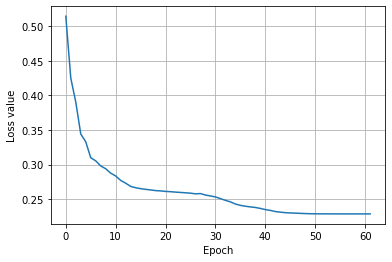

In [64]:
import matplotlib.pyplot as plt
plt.plot(convergence)
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.grid()


In [65]:
print(f" A total of {testing_data.shape[0]} testing samples were used and {len(testing())} were classified correctly.")

 A total of 30 testing samples were used and 28 were classified correctly.
